In [1]:

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, Function

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D

# Import from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Import FBP from CIL recon class
from cil.recon import FBP

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Load the example data set
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

# Preprocessing
scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale
data_sync = TransmissionAbsorptionConverter()(data_sync)
data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

# Crop data and reorder for ASTRA backend
data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)
data90.reorder(order='astra')

# Set up and run FBP for 90-angle dataset
recon90 = FBP(data90, backend='astra').run(verbose=0)

# Set up and run FBP for 15-angle dataset
data15 = Slicer(roi={'angle': (0,90,6)})(data90)
recon15 = FBP(data15, backend='astra').run(verbose=0)

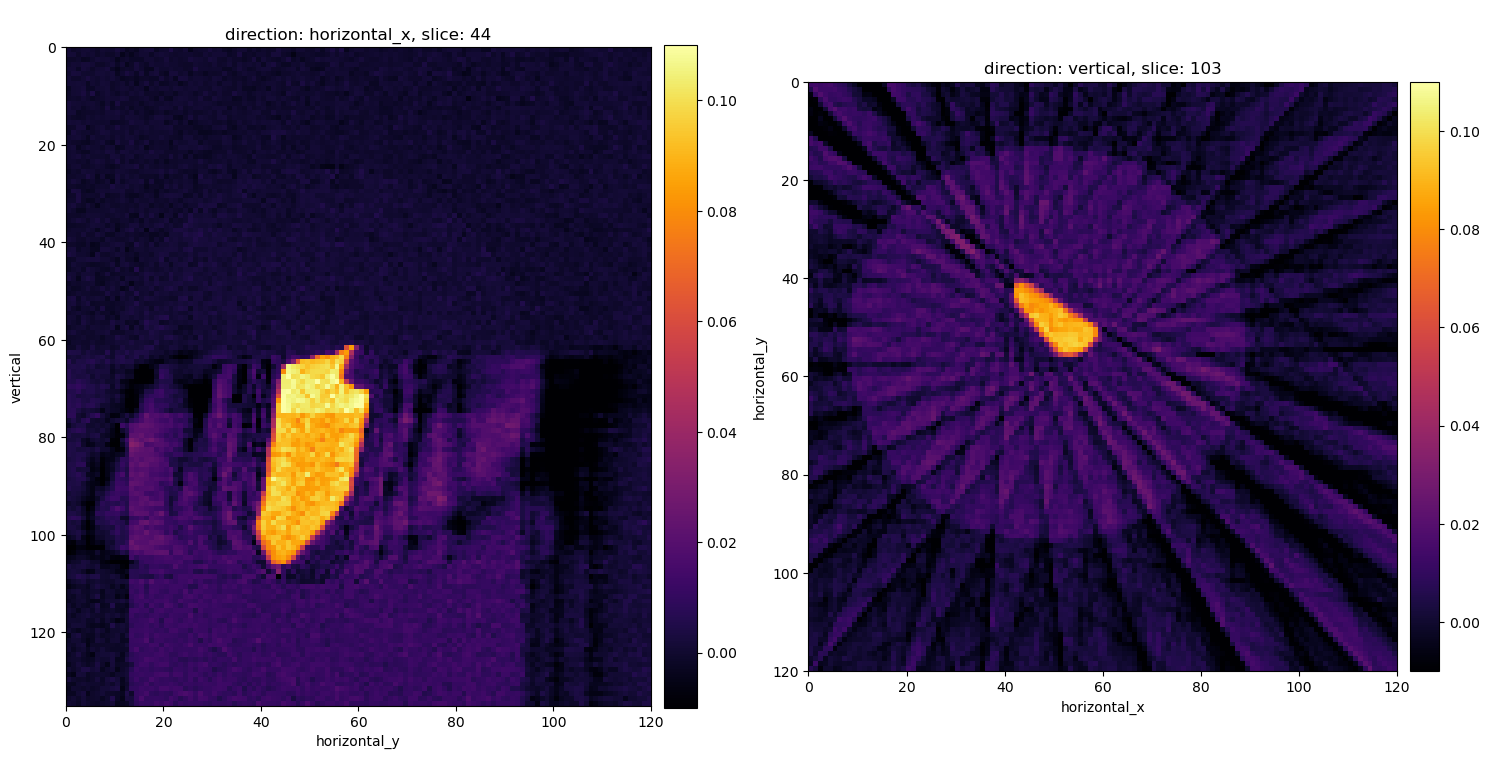

In [3]:
# Define custom parameters for show2D for visualizing all reconstructions consistently
sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11
slices = [('horizontal_x',sx),('vertical',sz)]

show2D(recon15, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

## FISTA - TV 

In [4]:
ag = data15.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag, device="gpu")
b = data15

F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha = 0.02
GTV = alpha*FGP_TV(device='gpu', nonnegativity=True) 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

  0%|          | 0/200 [00:00<?, ?it/s]

# FISTA with the proximal step a learned denoiser 

In [12]:
from deepinv.models import DnCNN
import torch
import deepinv

class DnCNNProximal(Function ):
    
    def __init__(self, device='cuda:1' ):
        self.device = torch.device('cuda:1')
        self.model = deepinv.models.DnCNN(in_channels=1, out_channels=1, pretrained='download_lipschitz', device=self.device)
        
        super(DnCNNProximal, self).__init__()

    def __call__(self, x):
        return 0 
    
    def proximal(self, x, tau, out=None): 
        x_torch = torch.tensor(x.array, device=self.device)
        x_torch = x_torch.squeeze(0).unsqueeze(1)
        out_torch = self.model(x_torch, tau)
        
        out_torch = out_torch.squeeze(1).unsqueeze(0)
        if out is None: 
            out = x.geometry.allocate(None)
            
        out.array[:] = out_torch.detach().cpu().numpy()
        return out 
        

In [13]:
from deepinv.models import DRUNet
import torch
import deepinv

class DRUNetProximal(Function ):
    
    def __init__(self, device='cuda:1' ):
        self.device = torch.device('cuda:1')
        self.model = deepinv.models.DRUNet(in_channels=1, out_channels=1, pretrained='download', device=self.device)
        
        super(DRUNetProximal, self).__init__()

    def __call__(self, x):
        return 0 
    
    def proximal(self, x, tau, out=None): 
        x_torch = torch.tensor(x.array, device=self.device)
        x_torch = x_torch.squeeze(0).unsqueeze(1)
        out_torch = self.model(x_torch, tau)
        
        out_torch = out_torch.squeeze(1).unsqueeze(0)
        if out is None: 
            out = x.geometry.allocate(None)
            
        out.array[:] = out_torch.detach().cpu().numpy()
        return out 
        

  0%|          | 0/10 [00:00<?, ?it/s]

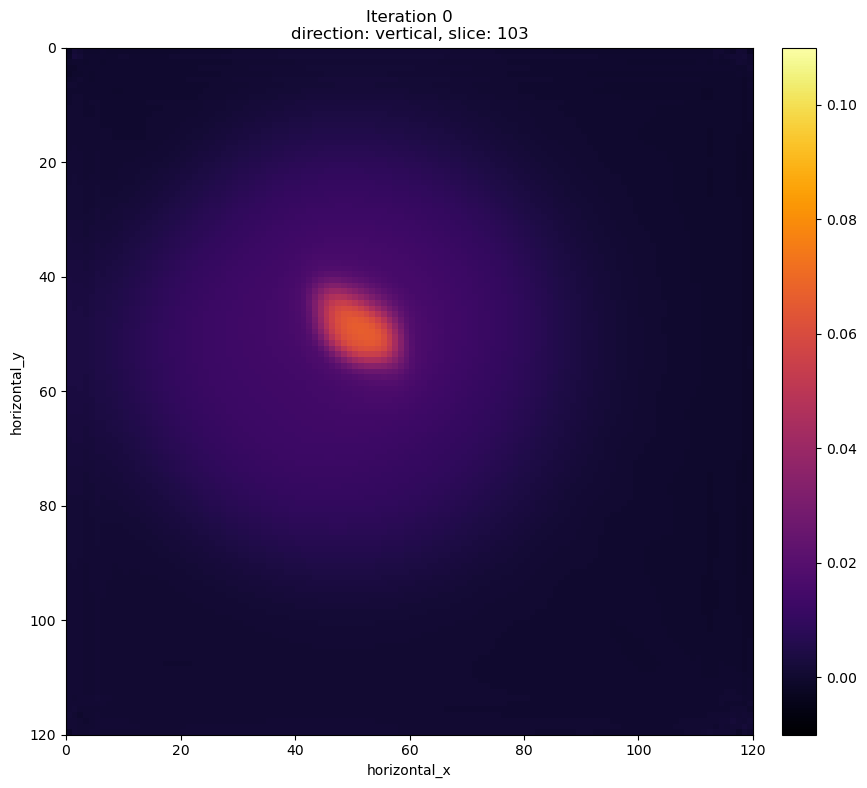

 55%|#####5    | 11/20 [00:00<?, ?it/s]

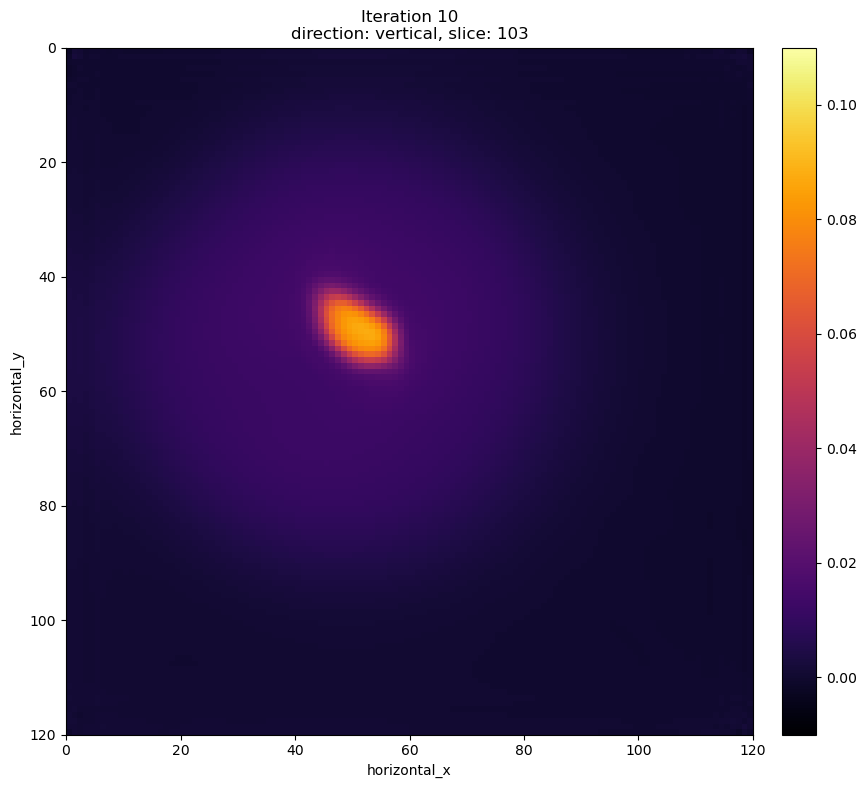

 70%|#######   | 21/30 [00:00<?, ?it/s]

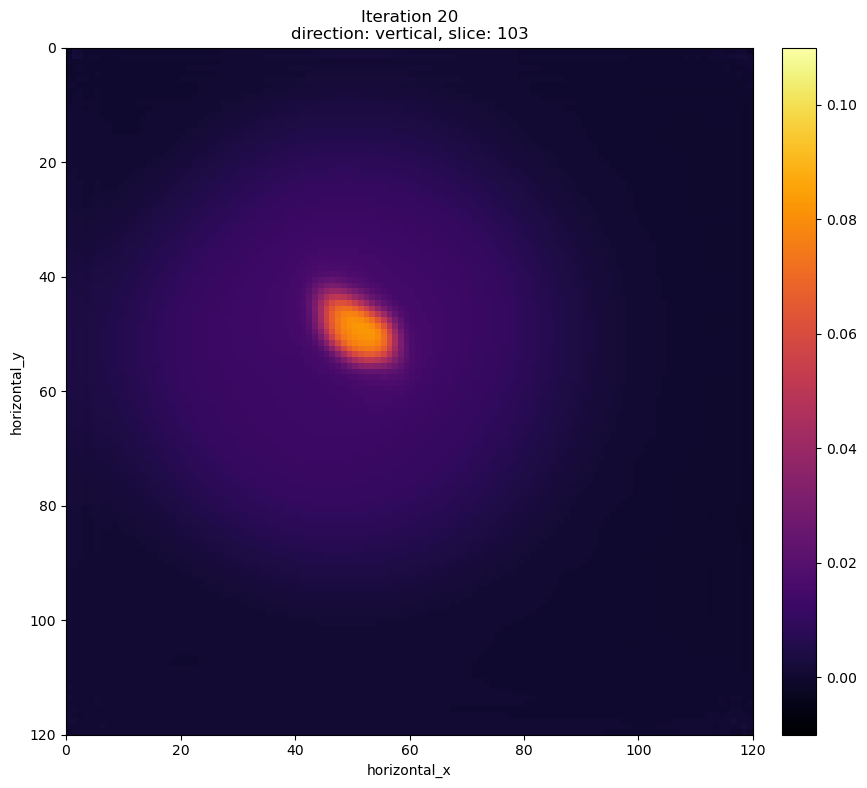

 78%|#######7  | 31/40 [00:00<?, ?it/s]

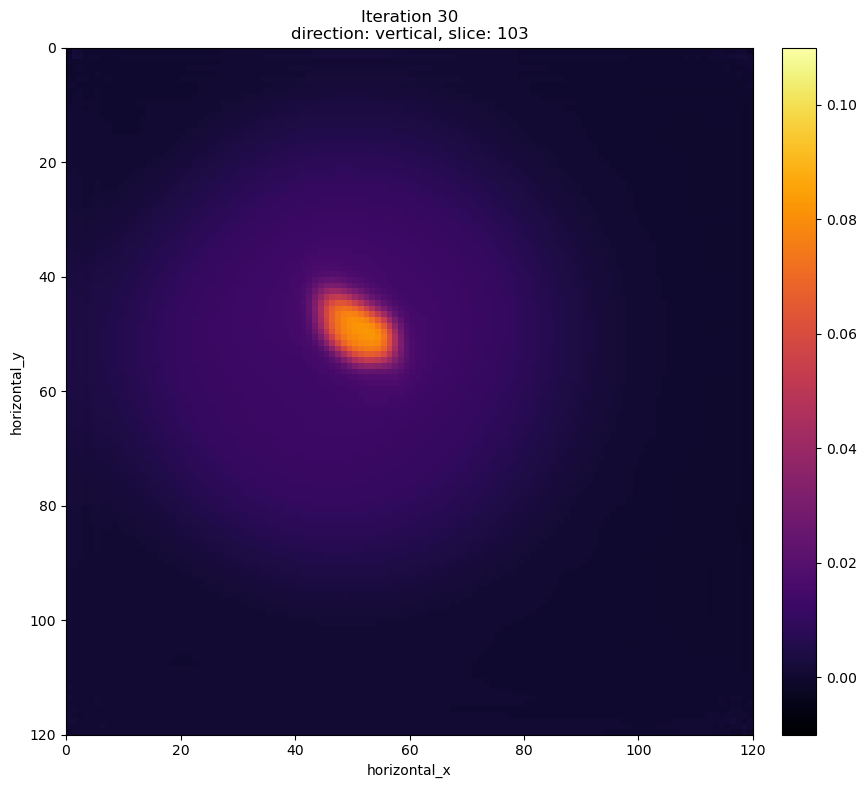

 82%|########2 | 41/50 [00:00<?, ?it/s]

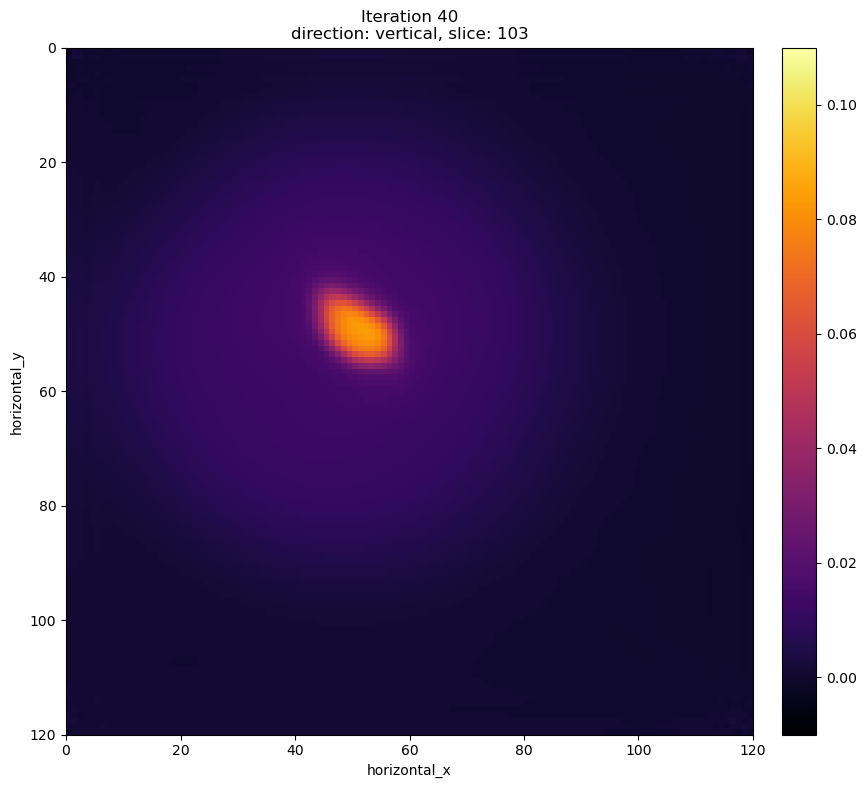

 85%|########5 | 51/60 [00:00<?, ?it/s]

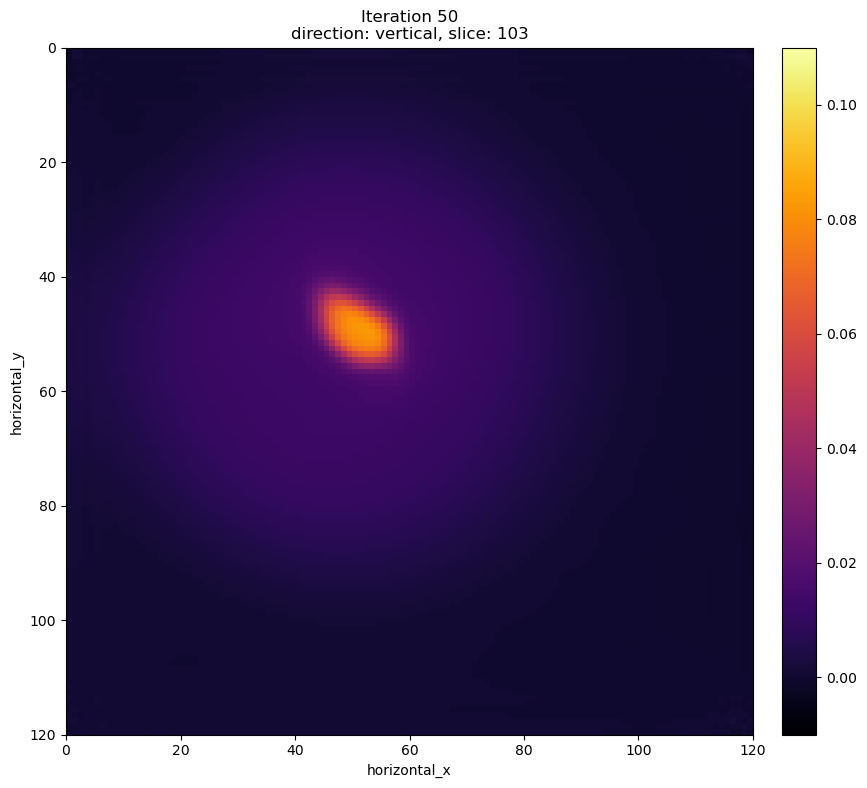

 87%|########7 | 61/70 [00:00<?, ?it/s]

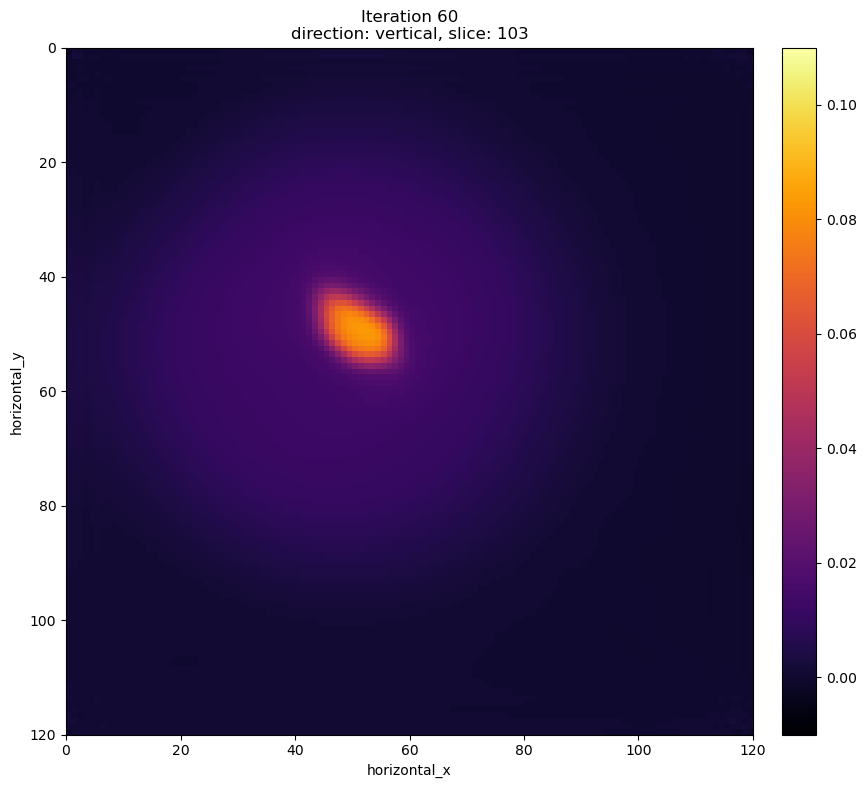

 89%|########8 | 71/80 [00:00<?, ?it/s]

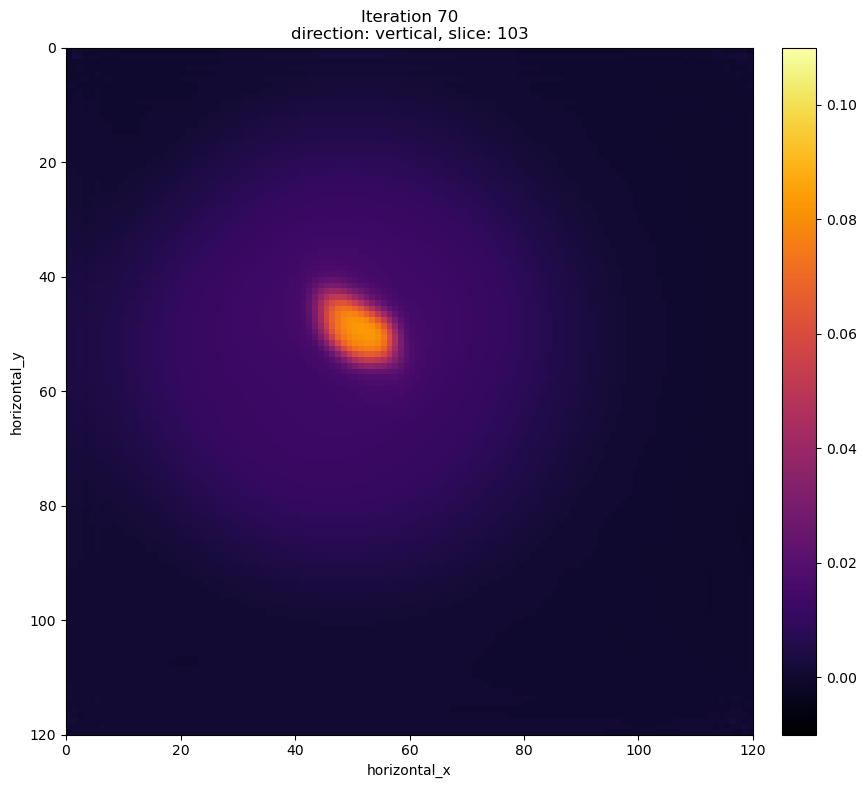

 90%|######### | 81/90 [00:00<?, ?it/s]

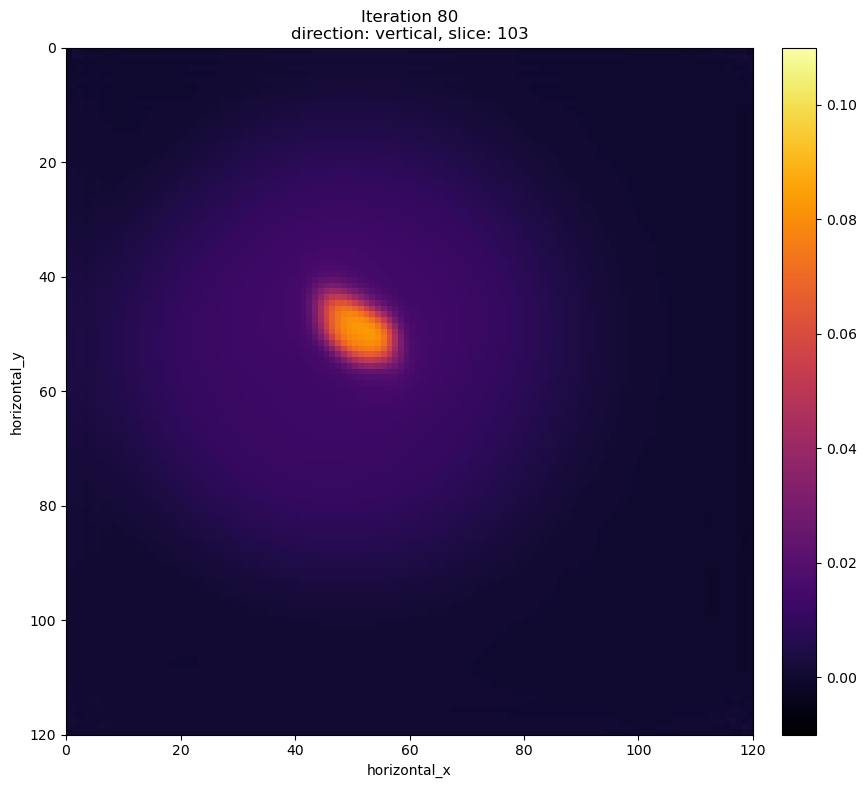

 91%|#########1| 91/100 [00:00<?, ?it/s]

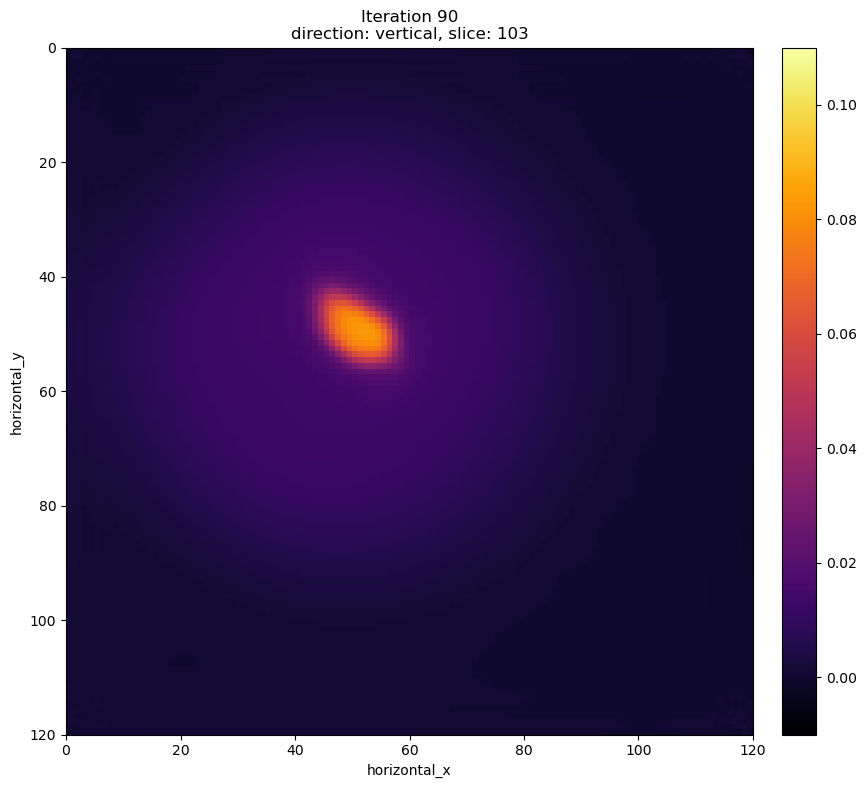

 92%|#########1| 101/110 [00:00<?, ?it/s]

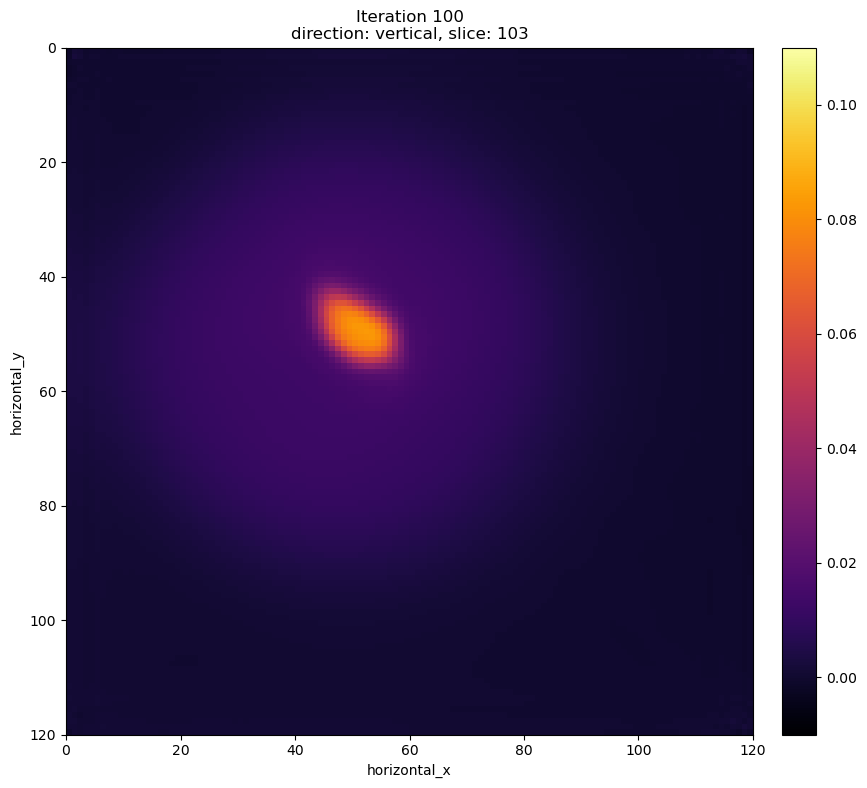

 92%|#########2| 111/120 [00:00<?, ?it/s]

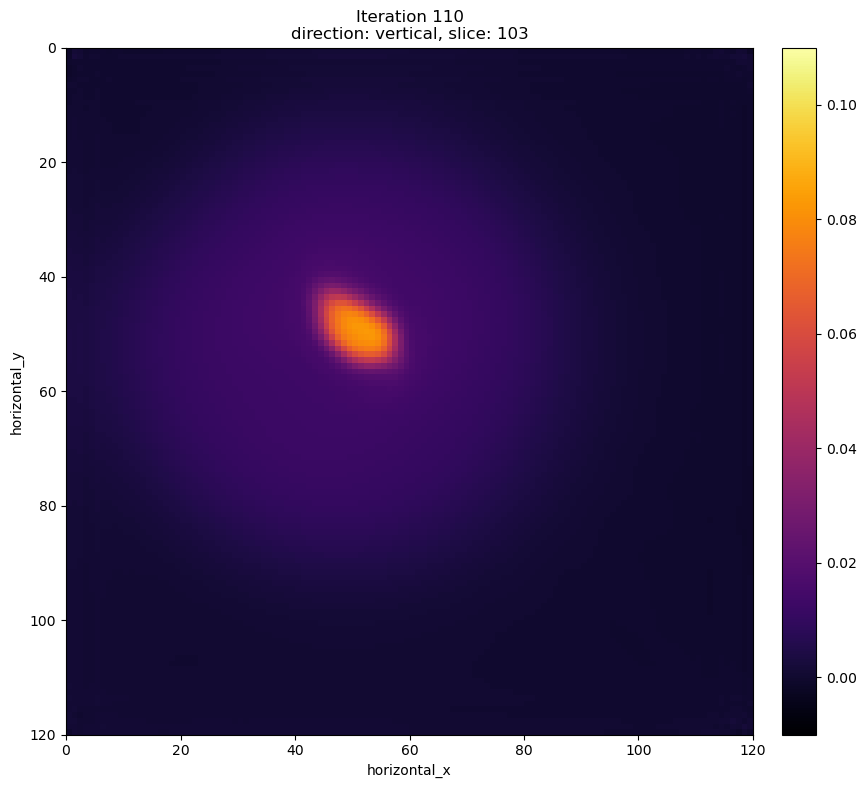

 93%|#########3| 121/130 [00:00<?, ?it/s]

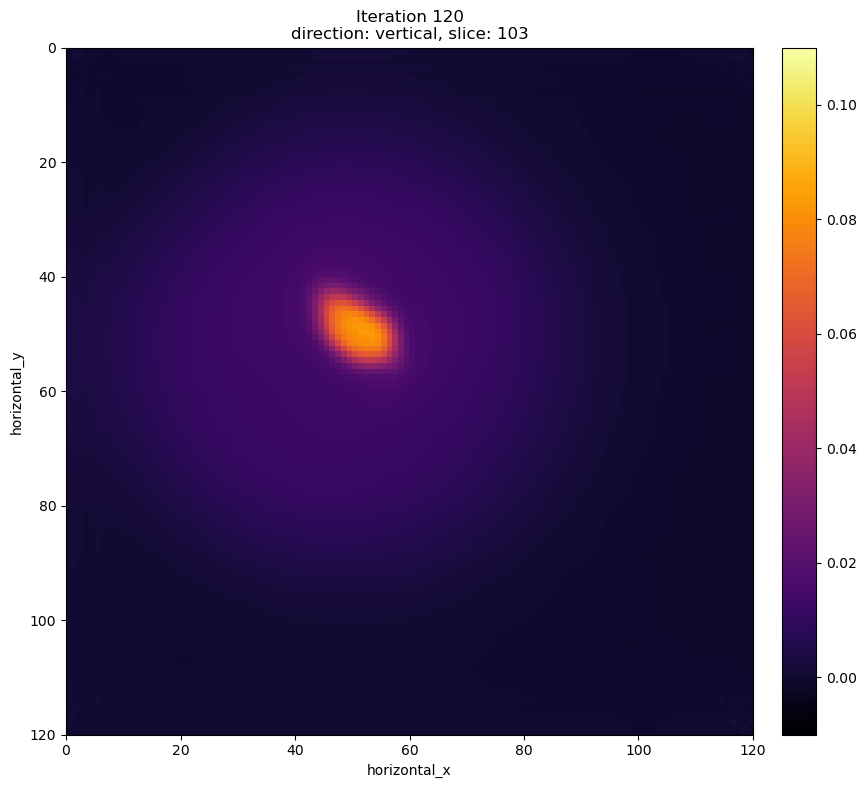

 94%|#########3| 131/140 [00:00<?, ?it/s]

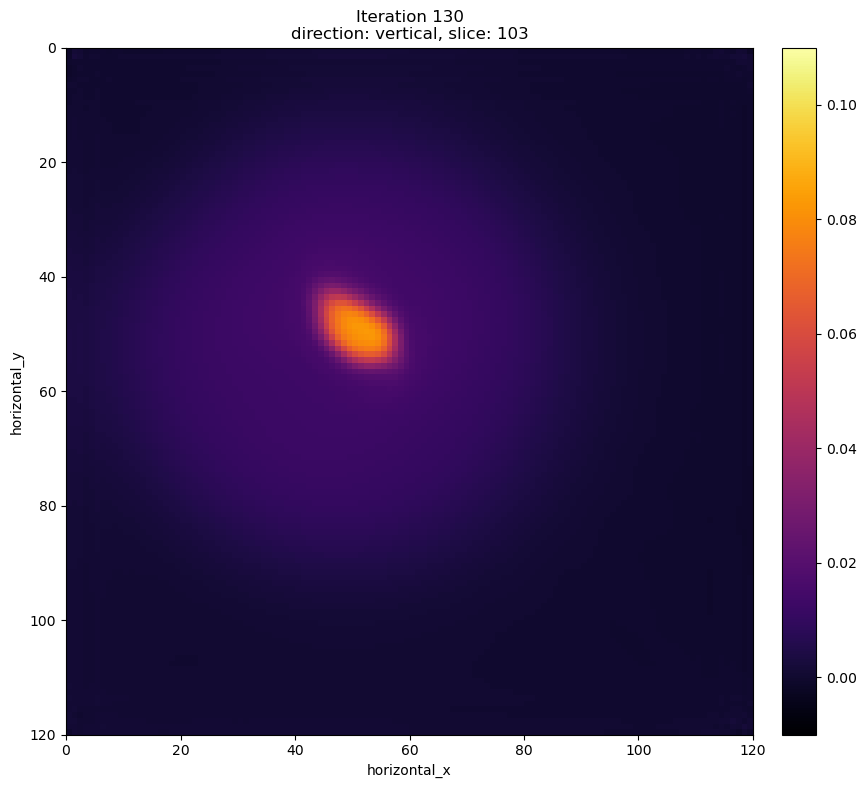

 94%|#########3| 141/150 [00:00<?, ?it/s]

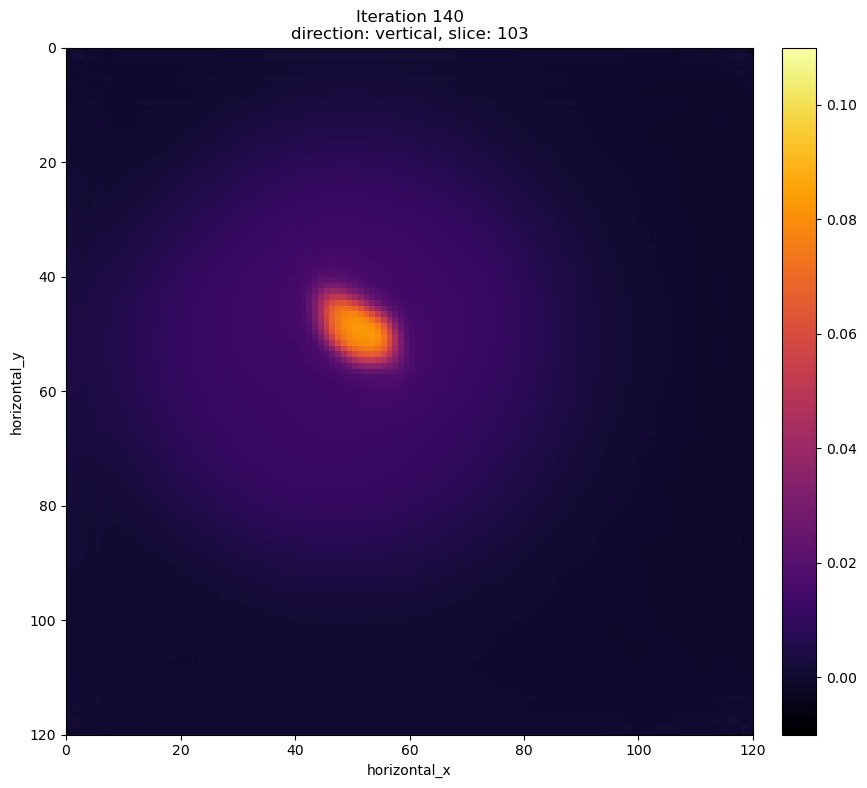

 94%|#########4| 151/160 [00:00<?, ?it/s]

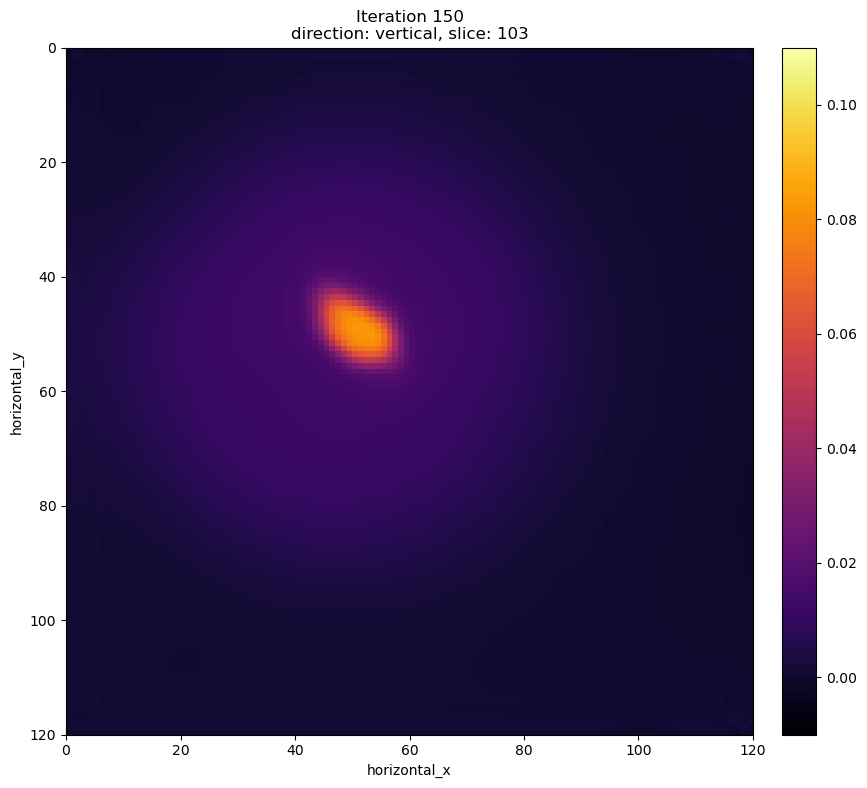

 95%|#########4| 161/170 [00:00<?, ?it/s]

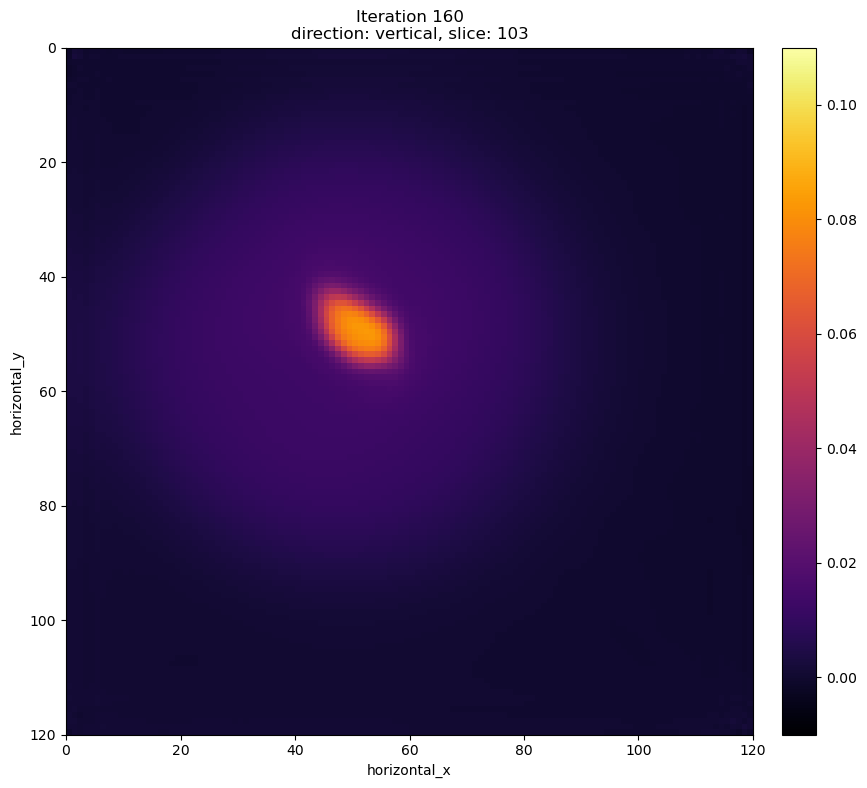

 95%|#########5| 171/180 [00:00<?, ?it/s]

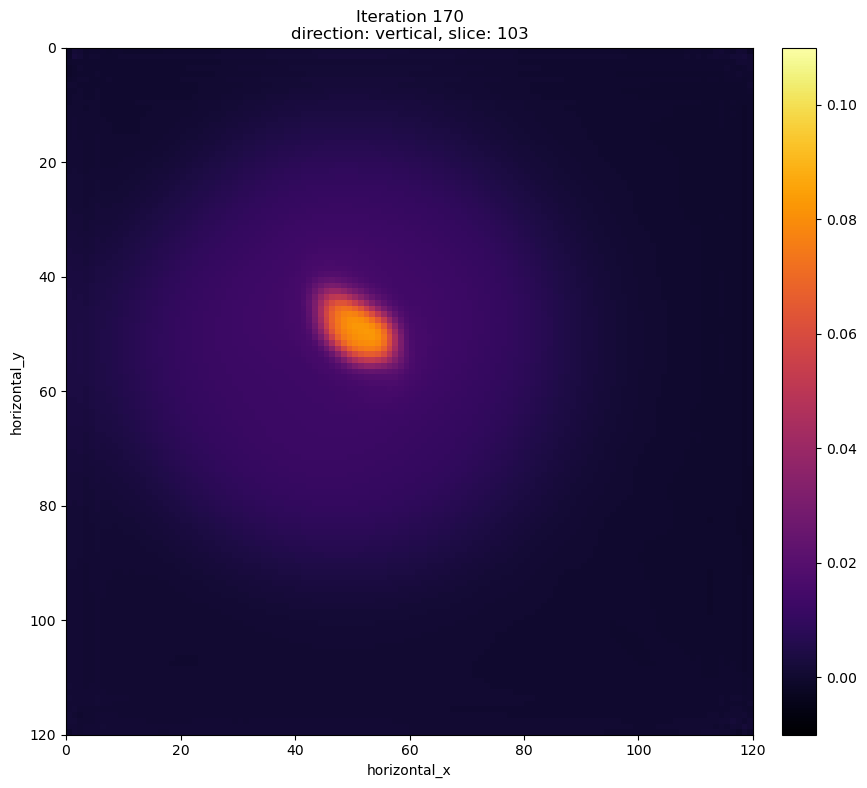

 95%|#########5| 181/190 [00:00<?, ?it/s]

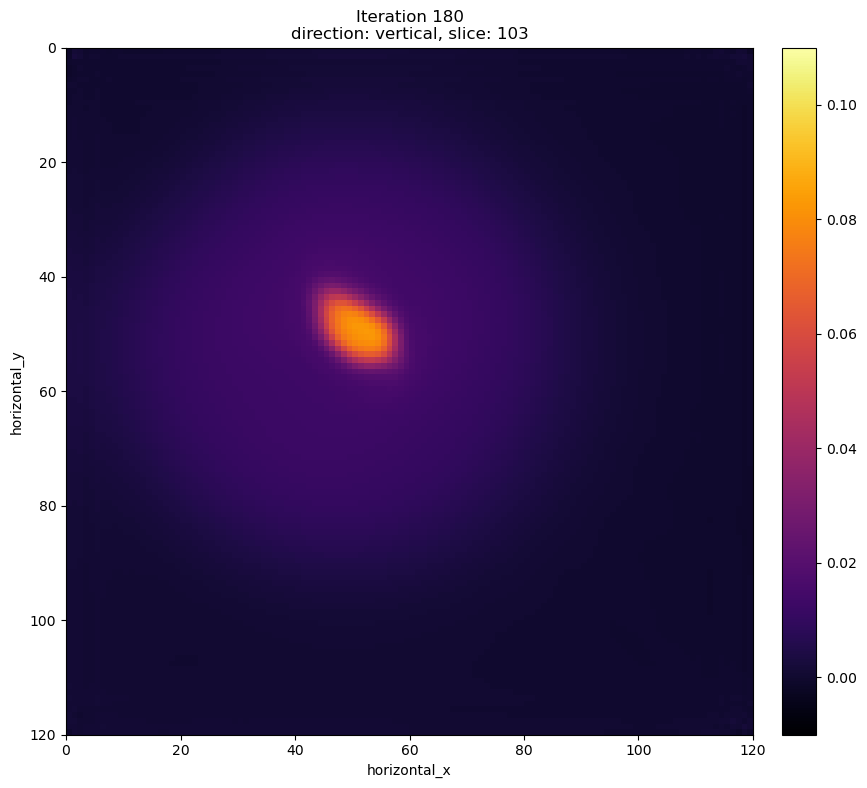

 96%|#########5| 191/200 [00:00<?, ?it/s]

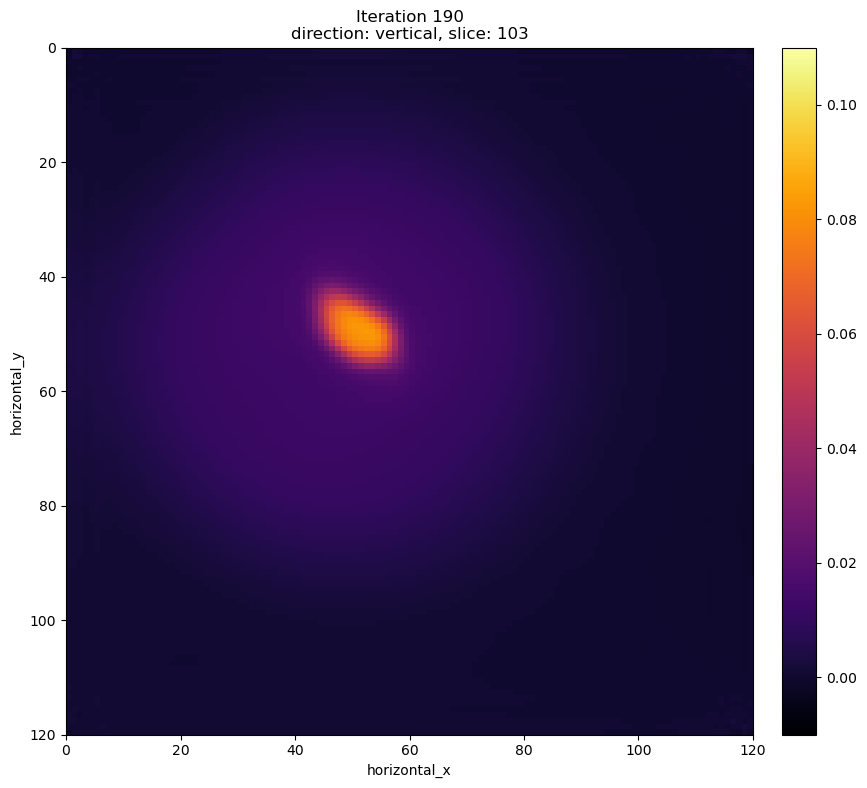

In [14]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
Regulariser = DnCNNProximal()
myFISTADnCNN = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(20):
    myFISTADnCNN.run(10,verbose=1)
    show2D(myFISTADnCNN.solution, title = 'Iteration {}'.format(i*10), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


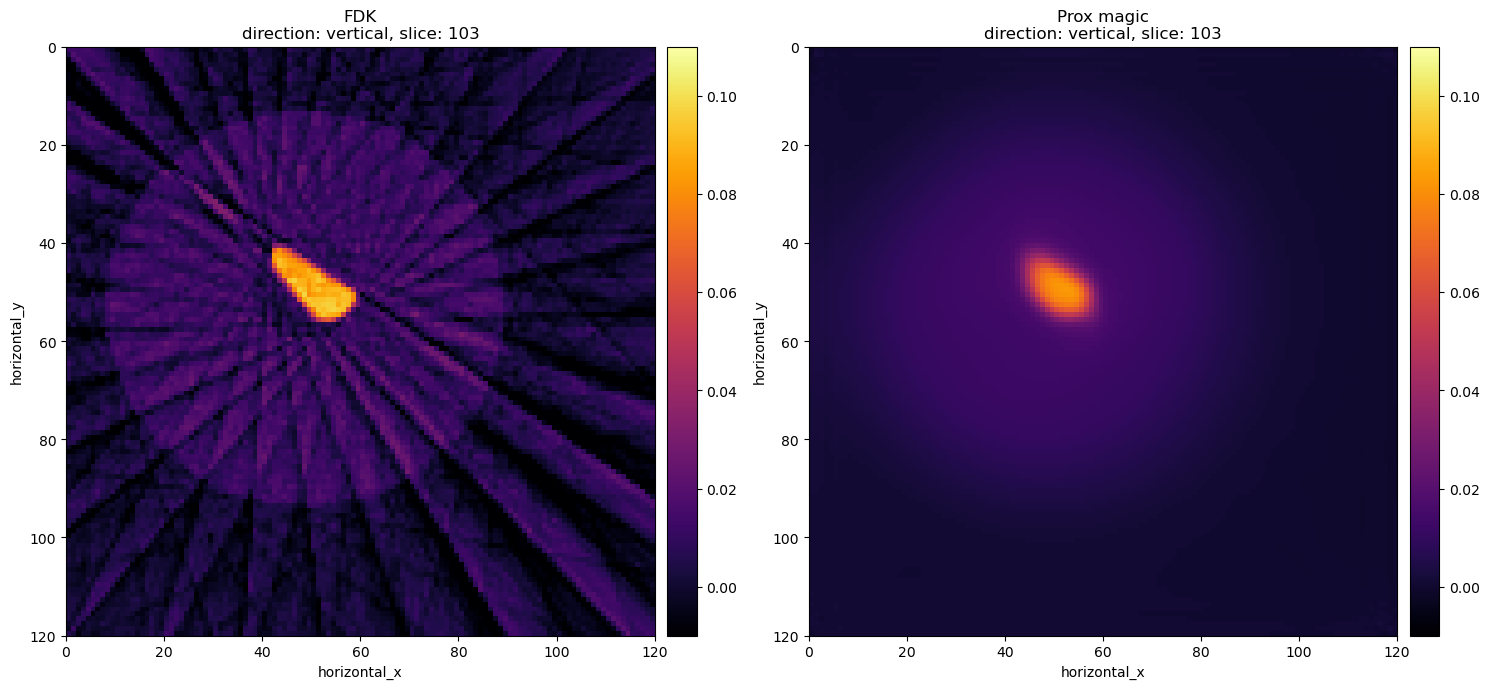

In [18]:
show2D([recon15, myFISTADnCNN.solution], title=['FDK', 'Prox magic'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


In [19]:

torch.cuda.empty_cache()

In [20]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha=0.02
Regulariser = alpha*DRUNetProximal()
myFISTADRUNet = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(20):
    myFISTADRUNet.run(10,verbose=1)
    show2D(myFISTADRUNet.solution, title = 'Iteration {}'.format(i*10), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


  0%|          | 0/10 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 476.00 MiB. GPU 1 has a total capacity of 31.73 GiB of which 248.12 MiB is free. Process 2666019 has 2.68 GiB memory in use. Process 3610936 has 9.70 GiB memory in use. Including non-PyTorch memory, this process has 14.93 GiB memory in use. Process 3707937 has 4.14 GiB memory in use. Of the allocated memory 13.80 GiB is allocated by PyTorch, and 785.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [27]:
x0_cropped = Slicer(roi={'vertical': (0,10,1)})(x0)
Regulariser.proximal(x0_cropped, 1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 1 has a total capacity of 31.73 GiB of which 2.12 MiB is free. Process 2666019 has 2.68 GiB memory in use. Process 3610936 has 9.70 GiB memory in use. Including non-PyTorch memory, this process has 15.56 GiB memory in use. Process 3716722 has 3.78 GiB memory in use. Of the allocated memory 15.13 GiB is allocated by PyTorch, and 78.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

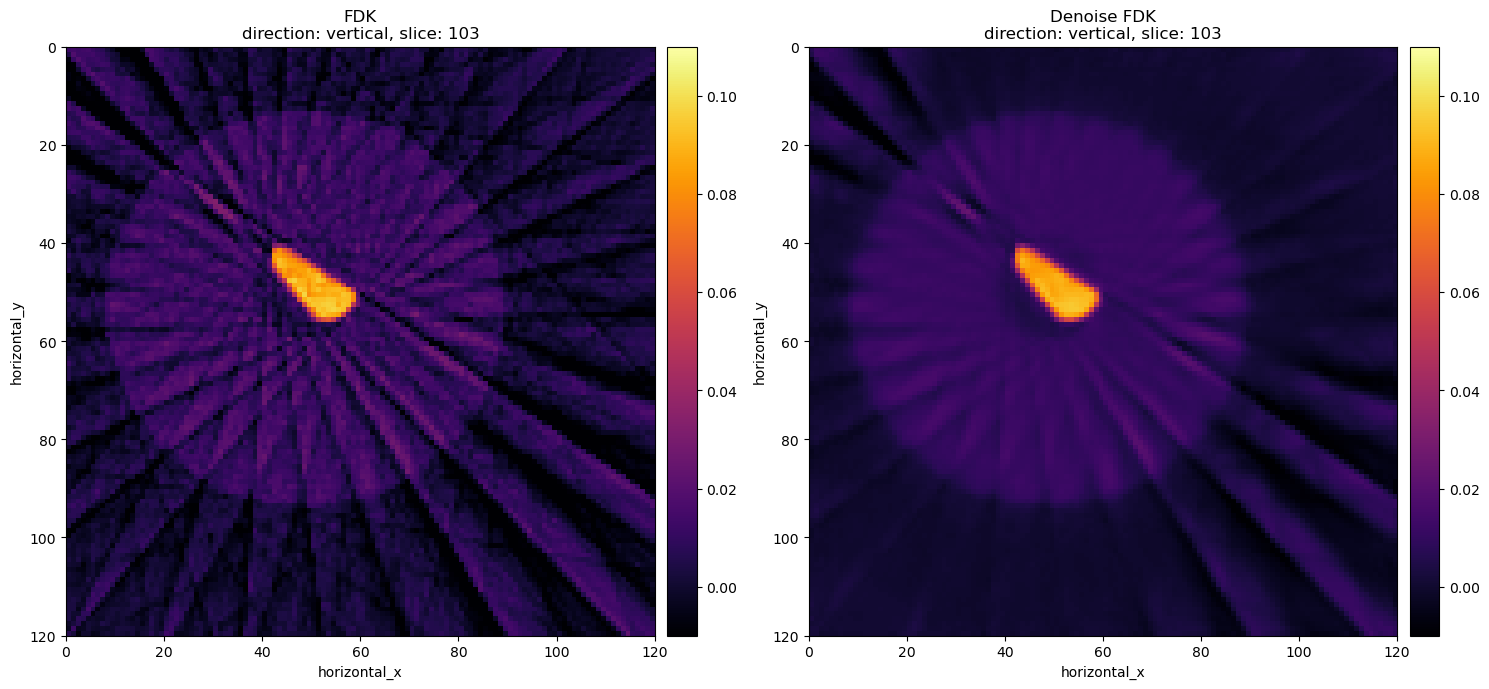

In [ ]:
show2D([recon15, myFISTADnCNN.solution, myFISTADRUNet.solution], title=['FDK', 'DnCNN prox', 'DRUNet prox'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')